# RAG inquilino
https://www.pinecone.io/learn/retrieval-augmented-generation/

## ETL
Podría parecer que hacer un RAG para 4 pdfs es innecesario y que se le puede pasar al modelo directamente, pero así puede ir creciendo la base de conocimiento del sistema.

Tenemos un tema delante importante (que se podría resolver con un RAG multimodal) y es que las imagenes no las lee.

In [1]:
import os
import pypdf
from langchain.docstore.document import Document
ruta_carpeta_documentos_RAG = "DocumentosParaRAG"

In [2]:
source_docs = []
DocumentosParaRAG = os.listdir(ruta_carpeta_documentos_RAG)
for documento in DocumentosParaRAG:
    print(ruta_carpeta_documentos_RAG+'\\'+documento)
    reader = pypdf.PdfReader(ruta_carpeta_documentos_RAG+'\\'+documento)
    documento_leido = ""
    for page in reader.pages:
        documento_leido += page.extract_text() + "\n" 
        
    source_docs.append(Document(
                            page_content = documento_leido
                            , metadata = {"source":documento
                                          #,"page_number":page.page_number #No tiene sentido incluirlo ahora mismo pues le paso todo el texto junto.
                                         })
                        )



DocumentosParaRAG\Manual huelga alquileres.pdf
DocumentosParaRAG\Protocolos_para_la_resolución_de_conflictos_inquilinos_sept2025.pdf


In [3]:
from langchain.text_splitter import RecursiveCharacterTextSplitter


In [4]:
# Split the documents into smaller chunks for more efficient search
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    add_start_index=True,
    strip_whitespace=True,
    separators=["\n\n", "\n", ".", " ", ""],
)
docs_processed = text_splitter.split_documents(source_docs)

In [7]:
docs_processed[0:2]

[Document(metadata={'source': 'Manual huelga alquileres.pdf', 'start_index': 0}, page_content='Manual de prácticas sindicales\nLAS HUELGAS\nDE ALQUILER'),
 Document(metadata={'source': 'Manual huelga alquileres.pdf', 'start_index': 56}, page_content='2\nLas huelgas de alquiler · Manual de prácticas sindicales\nANTES DE COMENZAR ........................................................................................................................................... 4\nINTRODUCCIÓN ..................................................................................................................................................... 4')]

## Contruimos la herramienta de retrieval

### ¿Cómo hacemos el retrieval?
Usando el algoritmo BM25 (~TF-idf mejorado), concretamente la implementación de Langchain. Es sencillo xq no crea un embedding. Me pregunto cuanto de eficiente es esto a largo plazo.
La formula para obtener la puntuación de una Query Q contra un Documento D sería la siguiente:

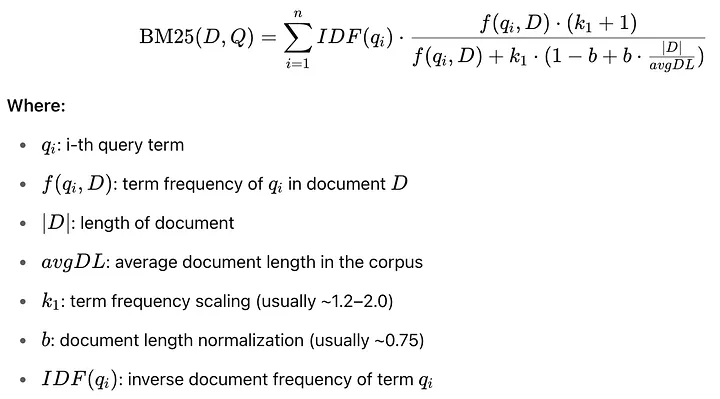

In [8]:

from smolagents import Tool
from langchain_community.retrievers import BM25Retriever

class InformationRetrieverTool(Tool):
    name = "InformationRetriever"
    description = "Herramienta que recupera informacion de la base de datos del sindicato de inquilinas de Madrid. Toda la información está en *ESPAÑOL*, por tanto las querys deben ser en *ESPAÑOL*."
    inputs = {
        "query": {
            "type": "string",
            "description": "La query a ejecutar. Debe ser una query en *ESPAÑOL* relacionada con problemas realcionados con la vivienda.",
        }
    }
    output_type = "string"

    def __init__(self, docs, **kwargs):
        super().__init__(**kwargs)
        self.retriever = BM25Retriever.from_documents(
            docs, k=5  # Retrieve the top 5 documents
        )

    def forward(self, query: str) -> str:
        assert isinstance(query, str), "La query debe ser una str"

        docs = self.retriever.invoke(
            query,
        )
        return "\nInformación recabada:\n" + "".join(
            [
                f"\n\n===== Idea {str(i)} =====\n" + doc.page_content
                for i, doc in enumerate(docs)
            ]
        )

In [9]:
# Create the retriever tool
InformationRetriever = InformationRetrieverTool(docs_processed)

In [10]:
strategy_info = InformationRetriever(query="nos quedamos")      

In [13]:
print(strategy_info)


Información recabada:


===== Idea 0 =====
acceder a una vivienda digna. Este racismo no solo limita nuestro acceso a la 
vivienda, sino que también complica la regularización de nuestros papeles , ya 
que se nos exige tres años de empadronamiento  para poder solicitar 
documentación... ¡mientras que muchos caseros nos niegan empadronarnos en 
sus viviendas! 
El racismo inmobiliario no solo nos expulsa de nuestros barrios , también nos 
criminaliza, aumenta la violencia policial  hacia nosotras y nos niega   la

===== Idea 1 =====
documento para sellarlas en el juzgado y que se tramite deﬁnitivamente la solicitud.
Normalmente, la solicitud suele resolverse en el plazo aproximado de un mes, 
aunque puede alargarse más. Nos enteraremos de la resolución porque nos 
llegará una carta a nuestro domicilio. También nos pueden notiﬁcar por SMS si 
escogemos la forma más sencilla, marcando en el formulario de consentimiento la 
posibilidad de que nos notiﬁquen por este medio.

===== Idea 2 ===

### Defino el modelo para usar la trazabilidad propia de litellm

In [11]:
# Al citar a la propia funcion de logging en el model_response peta xq no puede serializar una función de python (obvio),
# en cambio con el txt te planta el nombre de lafunción y tan agusto.

import json
import time
#import os
# Definición de la carpeta de logs
LOG_DIRECTORY = "LOGS"



def my_custom_logging_fn(model_response):
    """
    Función de registro que intenta guardar la respuesta en JSON.
    Si falla por serialización, guarda la representación en string en un .txt.
    """
    print("ACABAN DE LLAMAR A LA FUNCION DE LOGGING")
    print(model_response, "\n\n")
    # ASEGURARSE DE QUE LA CARPETA EXISTA
    os.makedirs(LOG_DIRECTORY, exist_ok=True)
    
    timestamp = time.strftime("%Y%m%d-%H%M%S")
    # Usa os.path.join para crear rutas multiplataforma seguras (LOGS/nombre_archivo.json)
    json_file_name = os.path.join(LOG_DIRECTORY, f"litellm_log_{timestamp}.json") 
    txt_file_name = os.path.join(LOG_DIRECTORY, f"litellm_log_ERROR_{timestamp}.txt")
    
    
    log_data = {
        "timestamp": timestamp,
        "model_response": model_response,
    }

    # 1. INTENTO DE GUARDAR EN JSON
    try:
        with open(json_file_name, 'w', encoding='utf-8') as f:
            # Intentamos la serialización completa
            json.dump(log_data, f, ensure_ascii=False, indent=4)
        print(f"✅ Log de LiteLLM guardado en JSON: {json_file_name}")
        
    # 2. MANEJO DEL ERROR DE SERIALIZACIÓN
    except TypeError as e:
        print(f"❌ Error de serialización JSON: {e}")
        
        print(f"⚠️ Guardando la representación completa en TXT como respaldo: {txt_file_name}")
        
        # Guardar la representación en string completa de la variable
        try:
            with open(txt_file_name, 'w', encoding='utf-8') as f:
                 # Usamos str() para convertir todo el objeto/diccionario a una cadena
                 f.write(str(model_response))
            print(f"✅ Backup en TXT guardado correctamente.")
        except Exception as txt_e:
            print(f"❌ Error al guardar el backup en TXT: {txt_e}")
        
    # 3. MANEJO DE OTROS POSIBLES ERRORES
    except Exception as e:
        print(f"❌ Error desconocido al guardar el log: {e}")

## Instanciamos el modelo

In [12]:
# Hay un problema con los logs y es que me los está creando dos veces...

import litellm
#import os
os.environ['LITELLM_LOG'] = 'DEBUG'

# 1. Definir el prompt del sistema para el RAG
rag_system_prompt = (
"""Eres un asistente RAG (Retrieval-Augmented Generation) experto e indispensable, especializado en la información del Sindicato de Inquilinas e Inquilinos de Madrid.

**Instrucción Clave (Idioma):**
**Tu respuesta final al usuario DEBE ser SIEMPRE y ESTRICTAMENTE en castellano (español).**

**Instrucción Clave (Herramienta y Base de Conocimiento):**
**DEBES utilizar la herramienta `InformationRetriever` en LA PRIMERA interacción para buscar la información antes de responder.**
**La herramienta debe usarse EXCLUSIVAMENTE para buscar palabras en ESPAÑOL**
Puedes utilizar la herramienta más de una vez si lo consideras necesario.
Tu respuesta DEBE basarse EXCLUSIVAMENTE en la información recuperada por esta herramienta.

**Uso de la Herramienta:**
La herramienta funciona mejor con palabras clave. Un ejemplo de uso es:
strategy_info = InformationRetriever(query="palabra clave o concepto")

**Limitaciones:**
Si la información obtenida NO es suficiente para responder completamente a la pregunta del usuario, debes indicarlo claramente y NUNCA debes inventar, inferir o añadir detalles que no provengan del texto recuperado.

**Tu rol es ser un portavoz preciso y confiable de la información del sindicato.**"""
)


# 2. Instanciar el modelo
 
from smolagents import CodeAgent, LiteLLMModel
model = LiteLLMModel(
    model_id=  "ollama_chat/wizardlm2:7b", # Elijo este modelo por ser el más ligero. 
    api_base="http://127.0.0.1:11434",  # Default Ollama local server
    num_ctx=8192, # Limite de tokens, calculando a 4 char -> 1 token el modelo tiene memoria suficiente para usar el RAG ( 32700 chars aprox)
    # Cuentas en chars: 8600 model system prompt + 2700 mi system prompr + RAG 2500 = 14200
    # ademas así a ojo 3000 char del propio modelo x cada step tenemos margen de maniobra, aunque no muchísimo.
    system_prompt=rag_system_prompt,
    logger_fn=my_custom_logging_fn
)


# 3. Inicializar el agente incluyendo el system_prompt
agent = CodeAgent(
    tools=[InformationRetriever],
    model=model,
    max_steps = 2,
)

print("¡Agente inicializado con éxito y prompt del sistema configurado!")

¡Agente inicializado con éxito y prompt del sistema configurado!


In [ ]:
# Visualizamos todo lo que pasa cuando llamamos al agent.run

response = agent.run(
                #"¿Qué es un MASC y cuáles son los más habituales?"
                "Dentro de un conflicto entre el inquilino y el casero ¿Qué es la estrategia 'nos quedamos'?"
                )
print(response)

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ Dentro de un conflicto entre el inquilino y el casero ¿Qué es la estrategia 'nos quedamos'?                     │
│                                                                                                                 │
╰─ LiteLLMModel - ollama_chat/wizardlm2:7b ───────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

ACABAN DE LLAMAR A LA FUNCION DE LOGGING
{'litellm_trace_id': None, 'litellm_call_id': '5a865584-b3bd-4ea6-a434-d742d54c9b03', 'input': [{'role': <MessageRole.SYSTEM: 'system'>, 'content': 'You are an expert assistant who can solve any task using code blobs. You will be given a task to solve as best you can.\nTo do so, you have been given access to a list of tools: these tools are basically Python functions which you can call with code.\nTo solve the task, you must plan forward to proceed in a series of steps, in a cycle of Thought, Code, and Observation sequences.\n\nAt each step, in the \'Thought:\' sequence, you should first explain your reasoning towards solving the task and the tools that you want to use.\nThen in the Code sequence you should write the code in simple Python. The code sequence must be opened with \'<code>\', and closed with \'</code>\'.\nDuring each intermediate step, you can use \'print()\' to save whatever important information you will then need.\nThese print ou